# Kaggle BCI Challenge @NER 2015

# Dataset
Each session include 60 target stimulus, however, the last session of each subject contains 100 target stimulus. Which makes 340 target stimulus for each subject

Data is collected at 200 Hz across 26 subjects (16 for training, 10 for testing). Each subject participated in 5 different sessions.

0 or 1 for bad or good feedback, respectively. Bad feedback is when the selected item is different from the expected item. Good feedback is when the selected item is similar to the expected item.

The Kaggle description and dataset can be downloaded [here.](https://www.kaggle.com/c/inria-bci-challenge)

## Section 1: Setup

In [ ]:
import numpy as np                                      # for dealing with data

import matplotlib.pyplot as plt                         # for plotting

import pandas as pd


from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
from scipy import interp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve


import os
from os import listdir
from os.path import isfile, join, isdir
import pickle

In [ ]:
pip install pyriemann


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Section 2: Pre-processing

**Step 1: Design a filter**<br>

- Filter.......: Butterworth, noncausal filtfilt
- Order......: 5nd
- High pass: 1 Hz
- Low pass.: 40 Hz

In [ ]:
# Create filtering variables
fs = 200.0     # 200 Hz sampling rate
lowcut = 1.0   # 0.1 Hz is the lowest frequency we will pass
highcut = 40.0 # 30  Hz is the highest frequency we will pass.

In [ ]:
def butter_bandpass_filter(raw_data, fs, lowcut = 1.0, highcut =40.0, order = 5):
    '''
    The filter I want to apply to my raw eeg data.
    :raw_data (nparray): data you want to process
    :fs (float): sampling rate
    :lowcut (float, optional): lowest frequency we will pass
    :highcut (float, optional): highest frequency we will pass
    :order (int, optional): order of filter
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    filted_data = sosfiltfilt(sos, raw_data)
    return filted_data

**Step 2: Determine our epoch, baseline, and window of focus**<br>

- Epoch...: 0 ~ 700ms
- Baseline: 0 ~ 100ms 

The following is a visual explanation of the baseline, ERP window selection, and sub-sampling routine (on a single channel, using the figure provided by Alessandro D'Amico):
<img src="images2/img1.png">


In [ ]:
epoch_s = 0      # epoch starting time relative to stmulus in miliseconds
epoch_e = 700    # epoch ending time relative to stmulus in miliseconds
bl_s = 0         # baseline starting time relative to stmulus in miliseconds
bl_e = 100       # baseline ending time relative to stmulus in miliseconds


# number of mark per epoch
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000)) 
epoch_len


140

**Step 3: Understand our data**<br>

- 16 participants in the training dataset.
- 10 participants in the testing dataset.
- 5 trials per participant
- 60 stimulus per trial in the first 4 trials, and 100 stimulus per trial in the last trial.
- Thus, 340 stimulus per trial.
- 56 channel EEG data


In [ ]:
train_subj_num = 16
test_subj_num = 10
stimulus_per_subj = 340
trial_per_subj = 5

channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
    'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
    'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'POz', 'P08', 'O1', 'O2']

In [ ]:
train_labels = pd.read_csv("/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/TrainLabels.csv")['Prediction'].values
sample_train_data = pd.read_csv("/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data_S02_Sess01.csv")

In [ ]:
train_labels

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
sample_train_data

,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,F1,Fz,F2,F4,F6,F8,FT7,FC5,FC3,FC1,FCz,FC2,FC4,FC6,FT8,T7,C5,C3,C1,Cz,C2,C4,C6,T8,TP7,CP5,CP3,CP1,CPz,CP2,CP4,CP6,TP8,P7,P5,P3,P1,Pz,P2,P4,P6,P8,PO7,POz,P08,O1,O2,EOG,FeedBackEvent
0,0.000,509.630351,609.688545,522.032153,454.102593,309.486489,524.804335,484.333383,587.340998,469.651564,247.106825,251.680416,238.013935,348.039096,408.843894,502.707412,504.673629,463.085294,395.590749,337.808592,267.018314,283.079554,270.515624,649.993451,663.049012,446.364318,470.295151,351.116452,359.205650,311.298295,266.686403,244.872624,202.507478,575.473604,394.143763,448.417153,326.251931,367.169282,247.517029,337.506284,345.791717,501.152414,402.065382,343.411139,465.289611,409.049490,443.363426,138.424719,287.616484,295.834834,485.530586,411.161892,448.726097,99.151239,613.529369,428.286969,378.933590,-906.668876,0
1,0.005,864.521388,1038.483761,917.023604,775.970207,576.123392,934.962455,833.427809,996.070640,823.715523,460.409341,465.030313,441.201496,628.975946,756.434962,872.495694,861.415367,798.087986,677.365165,623.370752,508.193783,512.288258,495.841717,1144.585008,1131.597641,749.031180,834.043217,619.189619,624.507890,551.888548,497.374128,436.376134,427.325354,987.265677,720.555023,813.863614,578.466324,642.237412,452.681326,577.889890,590.454944,866.078695,694.800372,604.856261,816.336703,746.231790,771.671000,278.892717,511.170438,528.713692,894.541770,735.827300,780.487458,239.407648,1067.349342,782.319229,711.286079,-1484.107119,0
2,0.010,754.576625,904.117869,803.235608,678.039830,489.573235,803.064230,706.392172,868.996293,717.565698,388.569839,394.768758,379.826053,555.309356,653.185683,766.072898,745.948105,693.288406,593.061604,535.254973,429.390156,445.437206,425.136630,1013.599199,996.489898,652.390926,716.494002,539.524892,549.674954,478.480250,425.287251,381.628236,498.306086,882.571279,621.825136,748.264493,505.420059,558.580324,389.428011,514.180164,525.358333,760.276145,609.129011,525.223388,717.181585,647.683856,678.274569,265.224686,444.570457,459.066586,870.217213,691.971456,689.656321,255.876323,933.617965,679.366071,699.014004,-1313.435186,0
3,0.015,801.593761,957.870867,834.026569,716.254450,519.006819,860.058239,769.518284,921.777695,756.664761,410.067278,417.994899,399.608393,587.168162,691.980899,815.895755,795.436463,742.142183,625.460667,561.609579,451.777212,468.246168,452.660252,1077.859103,1060.846816,704.019665,759.827324,560.488252,573.730687,502.729161,447.850111,402.855297,495.818307,931.908187,665.657960,745.650392,520.220755,583.863392,406.894625,540.120804,554.352956,808.953683,650.795796,556.902608,754.241278,676.268982,712.244725,269.958279,468.481277,487.899954,905.564172,723.595463,723.944898,247.990115,992.180045,713.405603,714.734949,-1391.966973,0
4,0.020,769.054899,920.060832,811.596932,692.750986,494.315305,817.206918,727.500302,892.004312,729.239924,397.256213,402.178257,377.499245,547.002933,653.102498,775.085700,749.784504,700.400379,603.423799,537.748568,431.351200,443.424115,432.407689,1014.281108,1017.001087,656.170430,725.898231,542.918843,546.629657,479.678270,424.625373,382.231349,346.029019,880.098686,628.335334,698.139269,502.342600,560.380349,386.267655,509.177156,525.075778,772.814487,621.610480,533.235953,717.301018,644.259888,678.692604,229.541357,445.684526,464.032652,769.258159,642.962959,687.852792,179.835749,949.832471,680.906506,607.057329,-1347.494166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131996,659.980,326.493877,148.619853,367.120885,329.607132,568.760051,228.081535,386.342230,193.539354,263.262863,620.628937,598.106157,607.176421,439.919605,293.807480,302.155618,324.880317,393.611637,310.798133,557.212696,540.165873,535.227083,560.822199,-6.531218,113.269217,358.388752,344.036890,404.993949,467.950472,516.830968,499.04

**Step 4: Create placeholder for loading our data**<br>
- There are 16 training participants, 5 trials per participant.
- There are 10 test participants, 5 trials per participant.
- There are 340 trials per participant, 56 channels for each trial, and our epoch length is 260.


In [ ]:
#Train
train_list_arr = np.array(sorted(listdir('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train')))
train_list_np = np.reshape(
    train_list_arr, (train_subj_num, trial_per_subj))

#Test
test_list_arr = np.array(sorted(listdir('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Test')))
test_list_np = np.reshape(
    test_list_arr, (test_subj_num, trial_per_subj))

print(train_list_np.shape, test_list_np.shape)

train_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
print(train_data_list.shape, test_data_list.shape)

(16, 5) (10, 5)
(0, 340, 56, 140) (0, 340, 56, 140)


**Step 5: Define our epoch function**<br>
We apply this function to each EEG trial.

In [ ]:
def generate_epoch(file_path, channels, fs, eeg_filter, stimulus_times=None, baseline=True,  epoch_s=0, epoch_e=700, bl_s=0, bl_e=100):
    """
    :description: Generating epoch given csv file. Make sure the csv file layout meets the requirement.
        It should contain 'Time' column that represents timepoints, and the time should start from 0.
        If your csv file does not have FeedBackEvent indicating the stimulus, you must pass stumulus_times.
        Here we used a butter bandpass filter, but you can change to your favorite one.

    :file_path (String): path to your csv file
    :channels ([String]): array of channels to epoch
    :fs (float): sampling rate
    :eeg_filter (function): the filter you want to apply to raw eeg data
    :stimulus_times ([float], optional): The time points that stimulus occur
    :baseline (boolean, optional): whether you want to apply baseline correction after epoching
    :epoch_s (int, optional): epoch starting time relative to stmulus in miliseconds
    :epoch_e (int, optional): epoch ending time relative to stmulus in miliseconds
    :bl_s (int, optional): baseline starting time relative to stmulus in miliseconds
    :bl_e (int, optional): baseline ending time relative to stmulus in miliseconds

    :rtype (3d-nparray): epoched data with dimension (stimulus_per_subj, number_of_channels, number_of_time_points)
    """
    # read dataand data selection
    train_data = pd.read_csv(file_path)

    train_data.loc[:, 'Time'] = train_data.loc[:, 'Time']*1000
    raw_eeg = train_data[channels].values.T

    time_df = train_data['Time'].values
    train_data['index'] = train_data.index.values
    if stimulus_times is None:
        mark_indices = np.asarray(
            train_data[train_data['FeedBackEvent'] == 1].index).flatten()
    else:
        mark_indices = np.round(np.asarray(
            stimulus_times).flatten() * fs).astype(int)

    # Define the bounds of our epoch as well as our baseline
    # index in epoch_df where our baseline begins
    b_s = int((abs(epoch_s) + bl_s) * (fs / 1000))
    # index in epoch_df where our baseline ends
    b_e = int((abs(epoch_s) + bl_e) * (fs / 1000))
    # Let's calculate the length our epoch with our given sampling rate
    epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

    # Let's define some helpful variables to make our extraction easier
    # effectively the number of indices before marker we want
    e_s = int((epoch_s * (fs / 1000)))
    # effectively the number of indices after marker we want
    e_e = int((epoch_e * (fs / 1000)))

    # Epoch the data
    final_epoch = np.empty((mark_indices.shape[0], epoch_len, 0), float)
    for channel in channels:
        epoch = np.zeros(shape=(int(mark_indices.shape[0]), epoch_len))
        raw_eeg = train_data[channel].values

        ################# You may want to apply your own filter ################
        clean_eeg = eeg_filter(raw_eeg, fs, lowcut, highcut, 5)
        ########################################################################

        for i, mark_idx in enumerate(mark_indices):
            # grab the appropriate samples around the stimulus onset
            epoch[i, :] = clean_eeg[mark_idx + e_s: mark_idx + e_e]

        # Baseline correction
        if baseline:
            for i in range(0, int(epoch.shape[0])):
                epoch[i, :] = epoch[i, :] - np.mean(epoch[i, b_s:b_e])

        # stack epoch of each channel
        final_epoch = np.dstack((final_epoch, epoch))
    final_epoch = np.swapaxes(final_epoch, 1, 2)
    return final_epoch

**Step 6: Epoch all data using epoch function we wrote**<br>
Now we have generated trainable data that can be fed into models. Skip this if we have already saved them in the first run.

In [ ]:
if not isfile("/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/train_data.npy"):
    for training_participant_id in range(train_subj_num):
        subject_dir_list = train_list_np[training_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        train_data_list = np.vstack((train_data_list, subject_epoch))

    print('Epoched training data shape: ' + str(train_data_list.shape))

    for testing_participant_id in range(test_subj_num):
        subject_dir_list = test_list_np[testing_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Test/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        test_data_list = np.vstack((test_data_list, subject_epoch))

    print('Epoched testing data shape: ' + str(test_data_list.shape))

    np.save('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/train_data', train_data_list)
    np.save('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/test_data', test_data_list)

Epoched training data shape: (16, 340, 56, 140)
Epoched testing data shape: (10, 340, 56, 140)


In [ ]:
train_data_list = np.load('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/train_data.npy')
test_data_list = np.load('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/test_data.npy')
print('Epoched training data shape: ' + str(train_data_list.shape))
print('Epoched testing data shape: ' + str(test_data_list.shape))


Epoched training data shape: (16, 340, 56, 140)
Epoched testing data shape: (10, 340, 56, 140)


#### Samples of Epoched EEG data
<table>
    <tbody>
        <tr>
            <td>
                <img src="./images2/Subject_2_Fz.png"/>
            </td>
            <td>
                <img src="./images2/Subject_2_Pz.png"/>
            </td>
        </tr>
        <tr>
            <td>
                <img src="./images2/Fz.png"/>
            </td>
            <td>
                <img src="./images2/Pz.png"/>
            </td>
        </tr>
    </tbody>
</table>

**Step 7: Apply xDawn Covariance algorithm and Tangent Space algorithm**<br>
After epoching our data, our data is in (subject, trial, channel, stimulus). Last two dimensions correspond to **spatial** and **temporal** dimensions.

Therefore, further feature exctraction and dimensionality reduction is necessary for standard machine learning algorithm to work.

In [ ]:
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

In [ ]:
Y_train = pd.read_csv('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/TrainLabels.csv')['Prediction'].values

In [ ]:
if not isfile('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/X_train.npy'):
    XC = XdawnCovariances(nfilter=5) # our transformer
    TS = TangentSpace(metric='riemann')
    # collapse first two dimension
    train_data = np.reshape(train_data_list, 
    (train_subj_num * stimulus_per_subj, len(channels), epoch_len))
    test_data = np.reshape(test_data_list, 
    (test_subj_num * stimulus_per_subj, len(channels), epoch_len))

    # transform our data
    X_train = XC.fit_transform(train_data, Y_train)
    X_train = TS.fit_transform(X_train)
    X_test = XC.transform(test_data)
    X_test = TS.transform(X_test)

    # save to local
    np.save('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/X_train', X_train)
    np.save('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/X_test', X_test)
    np.save('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Y_train', Y_train)

## Section 4: Cross Validation and Classification with Classic Machine Learning 

**Step 1: Load our data**<br>


In [ ]:
# Load our data
X_train = np.load('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/X_train.npy')
X_test = np.load('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/X_test.npy')
Y_train = np.load('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Y_train.npy')

# Only used for scoring
Y_test = np.reshape(pd.read_csv('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/true_labels.csv', header=None).values, 3400)


In [ ]:
print('Transformed training data shape: ' + str(X_train.shape))
print('Training label shape: ' + str(Y_train.shape))
print('Transformed testing data shape: ' + str(X_test.shape))
print('Testing label shape: ' + str(Y_test.shape))


Transformed training data shape: (5440, 210)
Training label shape: (5440,)
Transformed testing data shape: (3400, 210)
Testing label shape: (3400,)


**Step 2a: Use RandomForest for prediction**<br>


In [ ]:


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}

# Fit the grid search to the data
if not isfile('random_forest_gs'): 
    rf = RandomForestClassifier()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
               cv = 4, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    pickle.dump(grid_search, open('random_forest_gs', 'wb'))

In [ ]:
grid_search = pickle.load(open('random_forest_gs', 'rb'))
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'n_estimators': 200}


**Step 3a: Evaluate the performance of RandomForest**<br>


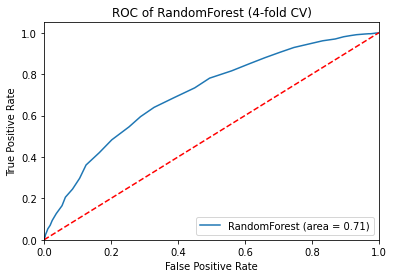

In [ ]:
# Predict the probability of our label score
Y_pred_proba = grid_search.predict_proba(X_test)

r_roc_auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RandomForest (4-fold CV)')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/iVAN/BCI_Challenge-master/Images_TW/Randomforest_ROC')
plt.show()

## Section 5: Deep Learning in BCI: EEGNET

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/iVAN/BCI_Challenge-master/arl-eegmodels-master')
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

import os
import scipy
from scipy.io import loadmat
from scipy import signal

import glob
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import time



import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.utils.data as Data
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint


# EEGNet-specific imports
from EEGModels import EEGNet
K.set_image_data_format('channels_last')

# Sklearn metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split


### Pre-Processing

In [ ]:
train_files = glob.glob('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data*.csv')
test_files = glob.glob('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Test/Data*.csv')
print(train_files[0:6])

['/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data_S02_Sess01.csv', '/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data_S02_Sess02.csv', '/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data_S02_Sess03.csv', '/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data_S02_Sess04.csv', '/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data_S02_Sess05.csv', '/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/Train/Data_S06_Sess01.csv']


In [ ]:
def butter_filter(order, low_pass, high_pass, fs,sig):
    nyq = 0.5 * fs
    lp = low_pass / nyq
    hp = high_pass / nyq
    sos = signal.butter(order, [lp, hp], btype='band', output = 'sos')
    return signal.sosfilt(sos, sig)

In [ ]:
def extract_d(files, e_s = None, baseline = True, bandpass = True):
    start = time.time()
    
    training_subjects = 16 #num of training subjects
    num_of_fb = 340 #num of feedbacks / subject
    freq = 200 #sampling rate
    epoch_time = 1.3 #proposed epoching time in seconds
    epoch = int(freq * epoch_time) #epoch in indices 
    #epoch_s = int(freq * e_s)
    num_of_cols = int(59) 
    eeg_cols = int(56)
    b_s = int(-0.4*freq) #index where baseline starts relative to feedback (-400ms)
    b_e = int(-0.3*freq) #index where baseline ends relative to feedback (-300ms)
    order = 5 #butterworth order
    low_pass = 1 #low frequency pass for butterworth filter
    high_pass = 40 #high frequency pass for butterworth filter
    
    channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
       'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
       'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
       'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
       'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
       'PO7', 'POz', 'P08', 'O1', 'O2']
    
    temp = np.empty((1,epoch,num_of_cols), float)
    for i, f in enumerate(files):
        print(i,f, temp.shape)
        df = pd.read_csv(f) #read each file
        index_fb = df[df['FeedBackEvent'] == 1].index.values
        df_array = np.array(df) 
        
        #uncomment below for butterworth filter
        if bandpass == True:
            eeg = df_array[:,1:57] #only eeg values to apply butterworth filter
            for i, channel in enumerate(channels):
                raw_eeg = df[channel].values
                eeg_filtered = butter_filter(order, low_pass, high_pass, freq, raw_eeg) #butterworth filter applied
                eeg[:,i] = eeg_filtered
            df = np.array(df)
            df[:,1:57] = eeg #replacing old eeg values with new ones
        else:
            df = np.array(df)
        
        for j, indx in enumerate(index_fb): #epoching 260 indexes (1.3 seconds) after each stimulus
            if e_s != None:
                epoch_array = df[indx:(indx+int(epoch)),:]
                epoch_array = epoch_array.reshape((1,int(epoch),int(epoch_array.shape[1])))
            else:
                epoch_array = df[indx:(indx+int(epoch)),:]
                epoch_array = epoch_array.reshape((1,int(epoch),int(epoch_array.shape[1])))

            #uncomment below for baseline correction
            if baseline == True:
                baseline_array = df[indx+b_s:indx+b_e, 1:57] #baseline correction of 100ms (20 indexes), 400ms to 300ms before fb
                baseline_array = baseline_array.reshape((1,20,int(baseline_array.shape[1])))
                baseline_mean = np.mean(baseline_array, axis = 1)
                epoch_array[:,:,1:57] = epoch_array[:,:,1:57] - baseline_mean #noise subtracted from epoched data
            
            if i == 0:
                temp = np.vstack((temp,epoch_array)) #stacking the first epoch
            else:
                temp = np.vstack((temp,epoch_array))
                
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return temp

In [ ]:
train = extract_d(train_files)
test = extract_d(test_files)

np.save('tr1.npy',train[1:,:,:])
np.save('te1.npy',test[1:,:,:])
train = np.load('tr1.npy')
test = np.load('te1.npy')

print(train.shape)
print(test.shape)

training_subjects = int(16)
num_of_fb = int(340)
freq = int(200)
epoch_time = 1.3
epoch = int(freq * epoch_time)
num_of_cols = int(59)
eeg_cols = int(56)

train = np.reshape(train, (5440, num_of_cols, epoch))
test = np.reshape(test, (3400, num_of_cols, epoch))

EEG_train = train[:,1:57,:].reshape(5440*epoch, eeg_cols)
EEG_test = test[:,1:57,:].reshape(3400*epoch, eeg_cols)

train_filtered = EEG_train.reshape(5440, int(eeg_cols), int(epoch))
test_filtered = EEG_test.reshape(3400, int(eeg_cols), int(epoch))

print(train_filtered.shape)
print(test_filtered.shape)

np.save('/content/drive/MyDrive/iVAN/BCI_Challenge-master/Try_no2/X_train_bwbs.npy',train_filtered)
np.save('/content/drive/MyDrive/iVAN/BCI_Challenge-master/Try_no2/X_test_bwbs.npy',test_filtered)

### EEG_Net


In [ ]:
##################### Import, process data for model ######################

train_labels = pd.read_csv('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/TrainLabels.csv')

X_train_valid = np.load('/content/drive/MyDrive/iVAN/BCI_Challenge-master/Try_no2/X_train_bwbs.npy')
X_train_valid = np.reshape(X_train_valid, (16*340, 56,260))

y_train_valid = train_labels['Prediction'].values

X_test = np.load('/content/drive/MyDrive/iVAN/BCI_Challenge-master/Try_no2/X_test_bwbs.npy')
X_test = np.reshape(X_test,(3400,56,260))

y_test = np.reshape(pd.read_csv('/content/drive/MyDrive/iVAN/BCI_Challenge-master/dataset/true_labels.csv', header=None).values, 3400)

# Partition
X_train = X_train_valid[1360:,:]
X_valid = X_train_valid[:1360,:]
Y_train = y_train_valid[1360:]
Y_valid = y_train_valid[:1360]

# Data contains 56 channels and 260 time-points. Set the number of kernels to 1.
kernels, chans, samples = 1, 56, 260

# Convert data to NCHW (kernels, channels, samples) format. 
X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_valid = X_valid.reshape(X_valid.shape[0], chans, samples, kernels)
X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels,)

print(str(X_train.shape[0]) + ' train samples')
print(str(X_valid.shape[0]) + ' validation samples')
print(str(X_test.shape[0]) + ' test samples')
print('********************************************')
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('********************************************')
print('X_valid shape: ' + str(X_valid.shape))
print('Y_valid shape: ' + str(Y_valid.shape))
print('********************************************')
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape)) 


4080 train samples
1360 validation samples
3400 test samples
********************************************
X_train shape: (4080, 56, 260, 1)
Y_train shape: (4080,)
********************************************
X_valid shape: (1360, 56, 260, 1)
Y_valid shape: (1360,)
********************************************
X_test shape: (3400, 56, 260, 1)
Y_test shape: (3400,)


In [ ]:
############################# EEGNet ##################################

# Configure the EEGNet-8,2,16 model with kernel length of 260 samples 
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 64, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')


# Compile the model and set the optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])


In [ ]:

# Set a valid path for system to record model checkpoints
filepath = '/content/drive/MyDrive/iVAN/BCI_Challenge-master/Try_no2/best_weights_bwbs.hdf5'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1,
                               save_best_only=True)

###############################################################################
# Since the classification task is imbalanced (significantly more trials in one
# class versus the others) can assign a weight to each class during 
# optimization to balance it out.
###############################################################################

# Syntax is {class_1:weight_1, class_2:weight_2,...}.
 
# Weighted loss
weight_0 = 1/(len([y for y in y_train_valid if y == 0]))
weight_1 = 1/(len([y for y in y_train_valid if y == 1]))

class_weights = {0:weight_0, 1:weight_1}

################################################################################
# Fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run.
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 34, epochs = 100, 
                        verbose = 2, validation_data=(X_valid, Y_valid),
                        callbacks=[checkpointer], class_weight = class_weights)

# Load optimal weights
model.load_weights(filepath)

###############################################################################
# Make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == y_test.argmax(axis=-1))
auc         = roc_auc_score(y_test,preds)

print("Classification Accuracy: %f " % (acc))
print("Area Under Curve: %f" % (auc))

Epoch 1/100
120/120 - 1s - loss: 2.2206e-04 - accuracy: 0.6578 - val_loss: 0.7120 - val_accuracy: 0.5588

Epoch 00001: val_loss improved from inf to 0.71199, saving model to /content/drive/MyDrive/iVAN/BCI_Challenge-master/Try_no2/best_weights_bwbs.hdf5
Epoch 2/100
120/120 - 1s - loss: 2.2213e-04 - accuracy: 0.6505 - val_loss: 0.7031 - val_accuracy: 0.5860

Epoch 00002: val_loss improved from 0.71199 to 0.70306, saving model to /content/drive/MyDrive/iVAN/BCI_Challenge-master/Try_no2/best_weights_bwbs.hdf5
Epoch 3/100
120/120 - 1s - loss: 2.2199e-04 - accuracy: 0.6571 - val_loss: 0.7379 - val_accuracy: 0.5368

Epoch 00003: val_loss did not improve from 0.70306
Epoch 4/100
120/120 - 1s - loss: 2.2379e-04 - accuracy: 0.6498 - val_loss: 0.7563 - val_accuracy: 0.5250

Epoch 00004: val_loss did not improve from 0.70306
Epoch 5/100
120/120 - 1s - loss: 2.2068e-04 - accuracy: 0.6520 - val_loss: 0.6891 - val_accuracy: 0.6015

Epoch 00005: val_loss improved from 0.70306 to 0.68915, saving model